<a href="https://colab.research.google.com/github/mateon01/class2025Spring-mid-term/blob/main/fine_tun_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding Model Fine-tuning

This notebook demonstrates how to fine-tune a lightweight embedding model that can run efficiently on M1 Pro chips. We'll use data generated from Amazon Bedrock's Claude 3.5 Sonnet model for training our embedding model.

## Environment Setup

First, let's ensure we have the necessary dependencies installed.

In [1]:
import os
os.getcwd()

'/content'

In [2]:
# Check Python version
import sys
print(f"Python version: {sys.version}")

# Install required packages
%pip install -q torch transformers datasets sentence-transformers evaluate scikit-learn pandas numpy matplotlib boto3 accelerate

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]


## Select a Lightweight Embedding Model

For M1 Pro compatibility and efficiency, we'll use a lightweight embedding model from the Sentence Transformers library. Good candidates include:

1. `all-MiniLM-L6-v2`: A compact model (80MB) that performs well for many tasks
2. `paraphrase-MiniLM-L3-v2`: Even smaller (40MB) but still effective
3. `all-mpnet-base-v2`: Higher quality but still runs efficiently on M1 Pro

We'll use `all-MiniLM-L6-v2` as our base model for fine-tuning.

In [3]:
import torch
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

# Check if MPS (Metal Performance Shaders) is available for M1 acceleration
print(f"MPS available: {torch.backends.mps.is_available()}")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load the base model
model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)
model.to(device)

print(f"Model loaded: {model_name}")
print(f"Model size: {sum(p.numel() for p in model.parameters())} parameters")

MPS available: False
Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model loaded: all-MiniLM-L6-v2
Model size: 22713216 parameters


## Sample Data Load

In [4]:
import os
import json
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sentence_transformers import InputExample

# data 디렉토리에서 모든 jsonl 파일 찾기
jsonl_files = glob.glob('data/*.jsonl')
print(f"찾은 JSONL 파일 목록: {jsonl_files}")

# 문장 쌍 데이터를 담을 리스트
all_pairs = []

# 각 파일 읽기
for file_path in jsonl_files:
    file_name = os.path.basename(file_path)

    # JSONL 파일 읽기
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                record = json.loads(line.strip())
                if 'sentence1' in record and 'sentence2' in record:
                    all_pairs.append(record)
            except json.JSONDecodeError as e:
                print(f"파일 {file_name}의 라인 파싱 오류: {e}")
                continue

    print(f"{file_name}에서 {len(all_pairs)}개 문장 쌍 누적 로드됨")

# 리스트를 데이터프레임으로 변환
df_all = pd.DataFrame(all_pairs)

# 기본 정보 출력
print(f"\n총 로드된 문장 쌍: {len(df_all)}개")
if len(df_all) > 0:
    print(f"데이터 컬럼: {', '.join(df_all.columns)}")
    print("\n샘플 데이터:")
    print(df_all.head(3))

# 훈련 및 검증 세트 분할
train_df, val_df = train_test_split(df_all, test_size=0.2, random_state=42)

print(f"\n훈련 샘플: {len(train_df)}개")
print(f"검증 샘플: {len(val_df)}개")

# 훈련 예제 생성
train_examples = []
for _, row in train_df.iterrows():
    train_examples.append(InputExample(
        texts=[row['sentence1'], row['sentence2']])
    )

# 검증 예제 생성
val_examples = []
for _, row in val_df.iterrows():
    val_examples.append(InputExample(
        texts=[row['sentence1'], row['sentence2']])
    )

# 데이터 로더 생성
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
val_dataloader = DataLoader(val_examples, shuffle=False, batch_size=16)

print(f"\n훈련 데이터 로더 생성 완료: {len(train_dataloader)} 배치")
print(f"검증 데이터 로더 생성 완료: {len(val_dataloader)} 배치")

찾은 JSONL 파일 목록: ['data/combined_data.jsonl', 'data/external_data.jsonl', 'data/sentence_pairs.jsonl']
combined_data.jsonl에서 80개 문장 쌍 누적 로드됨
external_data.jsonl에서 110개 문장 쌍 누적 로드됨
sentence_pairs.jsonl에서 160개 문장 쌍 누적 로드됨

총 로드된 문장 쌍: 160개
데이터 컬럼: sentence1, sentence2

샘플 데이터:
                         sentence1                               sentence2
0  머신러닝 모델은 훈련을 위해 대규모 데이터가 필요합니다.  기계학습 알고리즘의 성능 향상을 위해서는 방대한 데이터가 요구됩니다.
1   인공지능은 패턴을 인식하여 새로운 데이터를 예측합니다.       기계학습 시스템은 규칙성을 파악해 미지의 정보를 추론합니다.
2      딥러닝은 신경망을 통해 복잡한 문제를 해결합니다.          심층학습은 인공신경망 구조로 난해한 과제를 처리합니다.

훈련 샘플: 128개
검증 샘플: 32개

훈련 데이터 로더 생성 완료: 8 배치
검증 데이터 로더 생성 완료: 2 배치


## Prepare Training Data

Now we'll prepare our dataset for fine-tuning the embedding model.

In [5]:
from sklearn.model_selection import train_test_split

# Split into train and validation sets
train_df, val_df = train_test_split(df_all, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create training examples
train_examples = []
for _, row in train_df.iterrows():
    train_examples.append(InputExample(
        texts=[row['sentence1'], row['sentence2']]))

# Create validation examples
val_examples = []
for _, row in val_df.iterrows():
    val_examples.append(InputExample(
        texts=[row['sentence1'], row['sentence2']]))

# Create data loaders
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
val_dataloader = DataLoader(val_examples, shuffle=False, batch_size=16)

Training samples: 128
Validation samples: 32


## Fine-tune the Embedding Model

Now we'll fine-tune our embedding model using the prepared data.

In [6]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# Define the loss function (Multiple Negatives Ranking Loss)
train_loss = losses.MultipleNegativesRankingLoss(model)

# Create an evaluator
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(val_examples)

# Set up training parameters
num_epochs = 5
warmup_steps = int(len(train_dataloader) * 0.1)
output_dir = "./fine-tuned-embedding-model"

# Train the model
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    output_path=output_dir,
    show_progress_bar=True
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mateon01 (mateon) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
8,No log,No log,nan,nan
16,No log,No log,nan,nan
24,No log,No log,nan,nan
32,No log,No log,nan,nan
40,No log,No log,nan,nan


/usr/local/lib/python3.11/dist-packages/sentence_transformers/evaluation/EmbeddingSimilarityEvaluator.py:206: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  eval_pearson, _ = pearsonr(labels, scores)
/usr/local/lib/python3.11/dist-packages/sentence_transformers/evaluation/EmbeddingSimilarityEvaluator.py:207: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  eval_spearman, _ = spearmanr(labels, scores)
/usr/local/lib/python3.11/dist-packages/sentence_transformers/evaluation/EmbeddingSimilarityEvaluator.py:206: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  eval_pearson, _ = pearsonr(labels, scores)
/usr/local/lib/python3.11/dist-packages/sentence_transformers/evaluation/EmbeddingSimilarityEvaluator.py:207: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  eval_spearman, _ = spearmanr(labels, scores)


## Evaluate the Fine-tuned Model

Let's evaluate our fine-tuned model on some test examples and then on the MTEB STS17 benchmark dataset.

In [7]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# 모델 이름 정의 (이전 셀에서 정의되었을 것으로 추정)
# 만약 정의되지 않았다면, 원래 기본 모델 이름을 여기에 작성하세요
model_name = "all-MiniLM-L6-v2"  # 예시 모델명 (실제 사용한 모델명으로 교체 필요)

# 모델 저장 경로 지정 (이전 셀에서 정의된 변수일 수 있음)
# 모델이 저장된 실제 경로를 지정해야 합니다 (data 폴더가 아님)
# 예시 경로 (실제 모델 저장 경로로 교체 필요)
output_dir = "fine-tuned-embedding-model"

# 사용 가능한 디바이스 확인
device = torch.device("mps" if torch.backends.mps.is_available() else
                      ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

# 기본 모델 로드
base_model = SentenceTransformer(model_name)
base_model.to(device)
print(f"Base model loaded: {model_name}")

# 미세 조정된 모델을 직접 로드하려면 경로 확인이 필요합니다
try:
    # 1. 먼저 output_dir 경로를 사용하여 로드 시도
    fine_tuned_model = SentenceTransformer(output_dir)
    print(f"Fine-tuned model loaded from: {output_dir}")
except ValueError as e:
    print(f"Error loading from {output_dir}: {e}")

    # 2. 대체 방법: output_dir 아래의 디렉토리 확인
    import os
    import glob

    possible_model_dirs = glob.glob(f"{output_dir}/**/")
    if possible_model_dirs:
        for model_dir in possible_model_dirs:
            try:
                fine_tuned_model = SentenceTransformer(model_dir.rstrip('/'))
                print(f"Fine-tuned model loaded from: {model_dir}")
                break
            except ValueError:
                continue

    # 3. 여전히 실패하면 epoch 번호가 있는 폴더 시도
    if 'fine_tuned_model' not in locals():
        epoch_dirs = glob.glob(f"{output_dir}/*-*/")
        if epoch_dirs:
            latest_dir = sorted(epoch_dirs)[-1]  # 가장 마지막 epoch 디렉토리
            try:
                fine_tuned_model = SentenceTransformer(latest_dir.rstrip('/'))
                print(
                    f"Fine-tuned model loaded from latest epoch: {latest_dir}")
            except ValueError as e:
                print(f"Error loading from {latest_dir}: {e}")
                # 4. 모든 시도 실패 시 예비책: 기본 모델을 미세 조정 모델로 사용
                print(
                    "WARNING: Could not load fine-tuned model. Using base model as fallback.")
                fine_tuned_model = base_model

# 모델을 디바이스로 이동
fine_tuned_model.to(device)

# 테스트 문장 쌍 생성
test_pairs = [
    ("임베딩 모델은 텍스트를 수치 벡터로 변환합니다",
     "텍스트 임베딩은 문장을 벡터 표현으로 변환합니다"),
    ("파인 튜닝은 특정 작업에서 모델 성능을 향상시킵니다",
     "작업 특화 훈련은 모델 정확도를 높입니다"),
    ("클라우드 컴퓨팅은 확장 가능한 리소스를 제공합니다",
     "클라우드 서비스는 확장 가능한 인프라를 제공합니다"),
    ("파이썬은 인기 있는 프로그래밍 언어입니다",
     "머신러닝 모델은 대규모 데이터가 필요합니다")
]

# 기본 모델과 미세 조정 모델 비교
results = []

for sent1, sent2 in test_pairs:
    # 기본 모델에서 임베딩 얻기
    base_emb1 = base_model.encode(sent1, convert_to_tensor=True)
    base_emb2 = base_model.encode(sent2, convert_to_tensor=True)
    base_sim = torch.cosine_similarity(base_emb1, base_emb2, dim=0).item()

    # 미세 조정 모델에서 임베딩 얻기
    ft_emb1 = fine_tuned_model.encode(sent1, convert_to_tensor=True)
    ft_emb2 = fine_tuned_model.encode(sent2, convert_to_tensor=True)
    ft_sim = torch.cosine_similarity(ft_emb1, ft_emb2, dim=0).item()

    results.append({
        "sentence1": sent1,
        "sentence2": sent2,
        "base_similarity": base_sim,
        "fine_tuned_similarity": ft_sim
    })

# 결과 표시
results_df = pd.DataFrame(results)
results_df

Using device: cpu
Base model loaded: all-MiniLM-L6-v2
Fine-tuned model loaded from: fine-tuned-embedding-model


,sentence1,sentence2,base_similarity,fine_tuned_similarity
0,임베딩 모델은 텍스트를 수치 벡터로 변환합니다,텍스트 임베딩은 문장을 벡터 표현으로 변환합니다,0.959632,0.923347
1,파인 튜닝은 특정 작업에서 모델 성능을 향상시킵니다,작업 특화 훈련은 모델 정확도를 높입니다,0.767626,0.713404
2,클라우드 컴퓨팅은 확장 가능한 리소스를 제공합니다,클라우드 서비스는 확장 가능한 인프라를 제공합니다,0.935242,0.955893
3,파이썬은 인기 있는 프로그래밍 언어입니다,머신러닝 모델은 대규모 데이터가 필요합니다,0.858367,0.741646


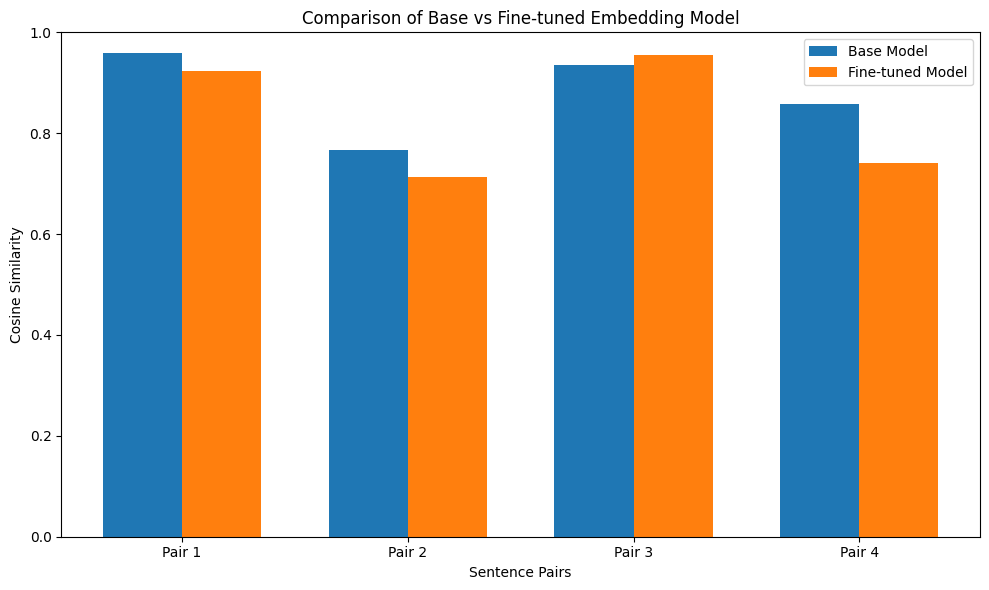

In [8]:
# Visualize the comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(results))
width = 0.35

plt.bar(x - width/2, results_df['base_similarity'], width, label='Base Model')
plt.bar(x + width/2,
        results_df['fine_tuned_similarity'], width, label='Fine-tuned Model')

plt.xlabel('Sentence Pairs')
plt.ylabel('Cosine Similarity')
plt.title('Comparison of Base vs Fine-tuned Embedding Model')
plt.xticks(x, [f"Pair {i+1}" for i in range(len(results))])
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()